In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap

In [3]:
import os

os.chdir('/content/drive/MyDrive/srikaran')
os.getcwd()

'/content/drive/MyDrive/srikaran'

In [4]:
os.makedirs('/content/datasets')

In [5]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

zip_path = '/content/drive/My Drive/srikaran/coco.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!
Unzipped successfully!


In [6]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [7]:
!ls /content/datasets/train/case90/case90_day0/scans

slice_0001_266_266_1.50_1.50.png  slice_0073_266_266_1.50_1.50.png
slice_0002_266_266_1.50_1.50.png  slice_0074_266_266_1.50_1.50.png
slice_0003_266_266_1.50_1.50.png  slice_0075_266_266_1.50_1.50.png
slice_0004_266_266_1.50_1.50.png  slice_0076_266_266_1.50_1.50.png
slice_0005_266_266_1.50_1.50.png  slice_0077_266_266_1.50_1.50.png
slice_0006_266_266_1.50_1.50.png  slice_0078_266_266_1.50_1.50.png
slice_0007_266_266_1.50_1.50.png  slice_0079_266_266_1.50_1.50.png
slice_0008_266_266_1.50_1.50.png  slice_0080_266_266_1.50_1.50.png
slice_0009_266_266_1.50_1.50.png  slice_0081_266_266_1.50_1.50.png
slice_0010_266_266_1.50_1.50.png  slice_0082_266_266_1.50_1.50.png
slice_0011_266_266_1.50_1.50.png  slice_0083_266_266_1.50_1.50.png
slice_0012_266_266_1.50_1.50.png  slice_0084_266_266_1.50_1.50.png
slice_0013_266_266_1.50_1.50.png  slice_0085_266_266_1.50_1.50.png
slice_0014_266_266_1.50_1.50.png  slice_0086_266_266_1.50_1.50.png
slice_0015_266_266_1.50_1.50.png  slice_0087_266_266_1.50_1.50

In [8]:
os.chdir('/content/drive/My Drive/srikaran/gi-tract-image-segmentation')
os.getcwd()

'/content/drive/My Drive/srikaran/gi-tract-image-segmentation'

In [9]:
import segmentation_models_pytorch as smp
from src.data import SegmentationDataset
from src.data import DataGenerator
from src.model import SimpleUNet
from src.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src.utils.plot_utils import plot_masks, display_comparison

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [13]:
train_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/train_json.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/val_json.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/test_json.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=1.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


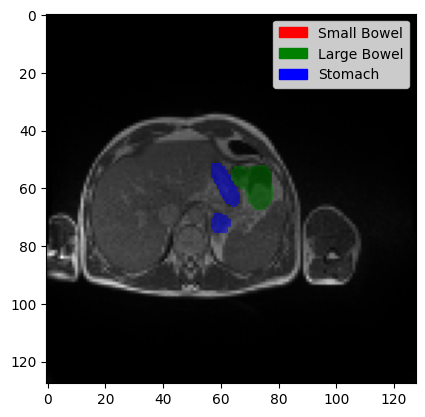

In [14]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class.__getitem__(0)

plot_masks(X, y)

In [15]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [16]:
print("Batch size:", train_loader.batch_size)
print("Num workers:", train_loader.num_workers)
print("Dataset size:", len(train_loader.dataset))
print("Number of batches:", len(train_loader))

Batch size: 32
Num workers: 0
Dataset size: 14269
Number of batches: 446


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
model = smp.Unet(
    encoder_name="efficientnet-b6",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Criterion
criterion = DiceLoss().to(device)
iou_criterion = IoU().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth
100%|██████████| 165M/165M [00:00<00:00, 246MB/s]


In [19]:
# Training and validation loops
train_losses = []
train_iou_0 = [] # small bowel
train_iou_1 = [] # large bowel
train_iou_2 = [] # stomach

val_losses = []
val_iou_0 = []
val_iou_1 = []
val_iou_2 = []

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_meter = AverageMeter()
    iou_meter_0 = AverageMeter()
    iou_meter_1 = AverageMeter()
    iou_meter_2 = AverageMeter()

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item(), data.size(0))
        iou_0, iou_1, iou_2 = iou_criterion(output, target)
        iou_meter_0.update(iou_0.item(), data.size(0))
        iou_meter_1.update(iou_1.item(), data.size(0))
        iou_meter_2.update(iou_2.item(), data.size(0))

    train_losses.append(train_loss_meter.avg)
    train_iou_0.append(iou_meter_0.avg)
    train_iou_1.append(iou_meter_1.avg)
    train_iou_2.append(iou_meter_2.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_iou_meter_0 = AverageMeter()
    val_iou_meter_1 = AverageMeter()
    val_iou_meter_2 = AverageMeter()

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 3, 1, 2)
            target = target.permute(0, 3, 1, 2)
            output = model(data)
            loss = criterion(output, target)

            val_loss_meter.update(loss.item(), data.size(0))
            iou_0, iou_1, iou_2 = iou_criterion(output, target)
            val_iou_meter_0.update(iou_0.item(), data.size(0))
            val_iou_meter_1.update(iou_1.item(), data.size(0))
            val_iou_meter_2.update(iou_2.item(), data.size(0))

    val_losses.append(val_loss_meter.avg)
    val_iou_0.append(val_iou_meter_0.avg)
    val_iou_1.append(val_iou_meter_1.avg)
    val_iou_2.append(val_iou_meter_2.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, \n \
            Train IOU SB: {iou_meter_0.avg:.4f}, Val IOU SB: {val_iou_meter_0.avg:.4f}, \n \
            Train IOU LB: {iou_meter_1.avg:.4f}, Val IOU LB: {val_iou_meter_1.avg:.4f}, \n \
            Train IOU S: {iou_meter_2.avg:.4f}, Val IOU S: {val_iou_meter_2.avg:.4f}')
    # Save model checkpoint
    torch.save(model.state_dict(), f'Large_UNET_model_epoch_{epoch}.pth')


Epoch 0 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.11it/s]


Epoch 0: Train Loss: 0.3722, Val Loss: 0.7446, 
             Train IOU SB: 0.0356, Val IOU SB: 0.0000, 
             Train IOU LB: 0.4924, Val IOU LB: 0.2908, 
             Train IOU S: 0.5441, Val IOU S: 0.1454


Epoch 1 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.14it/s]


Epoch 1: Train Loss: 0.1715, Val Loss: 0.3535, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.6766, Val IOU LB: 0.6330, 
             Train IOU S: 0.7103, Val IOU S: 0.6939


Epoch 2 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.15it/s]


Epoch 2: Train Loss: 0.1450, Val Loss: 0.3244, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7150, Val IOU LB: 0.6828, 
             Train IOU S: 0.7448, Val IOU S: 0.7194


Epoch 3 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.13it/s]


Epoch 3: Train Loss: 0.1347, Val Loss: 0.3102, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7320, Val IOU LB: 0.7108, 
             Train IOU S: 0.7580, Val IOU S: 0.7142


Epoch 4 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.09it/s]


Epoch 4: Train Loss: 0.1287, Val Loss: 0.3917, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7417, Val IOU LB: 0.6780, 
             Train IOU S: 0.7664, Val IOU S: 0.5044


Epoch 5 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.09it/s]


Epoch 5: Train Loss: 0.1214, Val Loss: 0.3263, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7536, Val IOU LB: 0.6898, 
             Train IOU S: 0.7756, Val IOU S: 0.6821


Epoch 6 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.09it/s]


Epoch 6: Train Loss: 0.1161, Val Loss: 0.3000, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7624, Val IOU LB: 0.7317, 
             Train IOU S: 0.7811, Val IOU S: 0.7342


Epoch 7 Validation: 100%|██████████| 145/145 [00:24<00:00,  6.04it/s]


Epoch 7: Train Loss: 0.1098, Val Loss: 0.3041, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7711, Val IOU LB: 0.7126, 
             Train IOU S: 0.7918, Val IOU S: 0.7344


Epoch 8 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.15it/s]


Epoch 8: Train Loss: 0.1099, Val Loss: 0.3085, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7714, Val IOU LB: 0.7050, 
             Train IOU S: 0.7902, Val IOU S: 0.7236


Epoch 9 Validation: 100%|██████████| 145/145 [00:23<00:00,  6.15it/s]


Epoch 9: Train Loss: 0.1065, Val Loss: 0.3024, 
             Train IOU SB: 0.0000, Val IOU SB: 0.0000, 
             Train IOU LB: 0.7758, Val IOU LB: 0.7185, 
             Train IOU S: 0.7971, Val IOU S: 0.7378


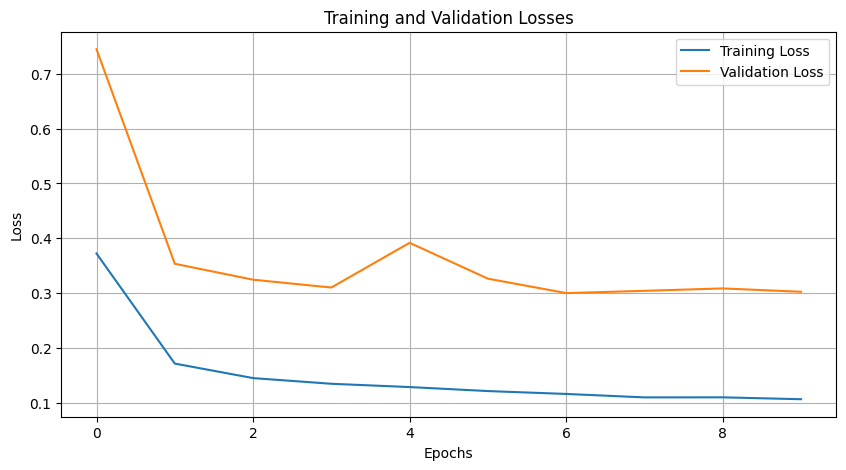

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model = smp.Unet(
    encoder_name="efficientnet-b6",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

# Load the saved model weights
model.load_state_dict(torch.load('Large_UNET_model_epoch_6.pth'))

# Set the model to evaluation mode if you are making predictions
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          56, 14, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          14, 56, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [24]:
images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data in test_loader:
        # Assuming your DataLoader returns a tuple of (images, labels)
        images = data[0]
        images = images.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # print(images.shape)
        # Generate predictions
        output = model(images)
        predictions.append(output)
        # print(output.shape)

        mask = data[1].permute(0, 3, 1, 2).to(device)
        masks.append(mask)
        # print(mask.shape)

        dice_loss = criterion(output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(output, mask)

        test_dice_loss_meter.update(dice_loss.item(), output.size(0))
        test_iou_meter_0.update(iou_value0.item(), output.size(0))
        test_iou_meter_1.update(iou_value1.item(), output.size(0))
        test_iou_meter_2.update(iou_value2.item(), output.size(0))
        # break

print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

Test Dice Loss: 0.2951, 
         IOU for SB:  0.0000, 
         IOU for LB:  0.7327, 
         IOU for S:  0.7278


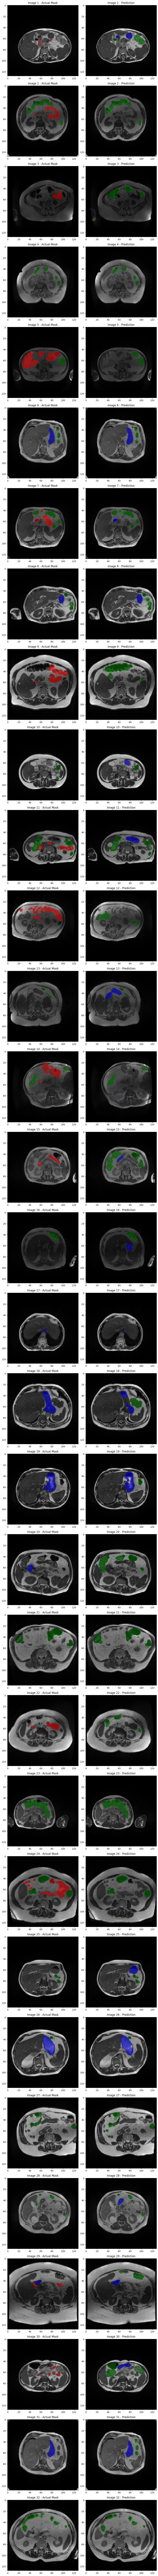

In [25]:
img_s = images_test[0]
pred_s = predictions[0]
mask_s = masks[0]

display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())